In [134]:
import numpy as np
import pandas as pd
import fasttext
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix
import math
import operator
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


In [135]:
df_sample = pd.read_csv('datasets/random_sample_data.csv')

In [136]:
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample.tail()

,raw_comment,tokenized_comment,label
3448,These new agri. laws are not feasible in india...,these new agri law be not feasible in india fi...,0
3450,"If this is Farmer protest , why we see only pu...",if this be farmer protest why we see only punj...,1
3451,UP police is trying to clear their image in th...,up police be try to clear their image in the w...,0
3452,Support farmers,support farmer,0
3453,"I agree to many points you made, but MSP is a ...",i agree to many point you make but msp be a do...,1


In [137]:
comments = df_sample['tokenized_comment']
labels = df_sample['label']

### Weak Supervision

In [138]:
def n_gram_count(sentence: str, n_gram_phrase: str):
    return sentence.count(n_gram_phrase)

### Modified TF-IDF

In [139]:

def IDF(corpus, unique_words):
   idf_dict = {}
   N = len(corpus)
   for i in unique_words:
     count = 0
     for sen in corpus:
       if n_gram_count(sen,i) != 0:
         count = count+1
       idf_dict[i] = (math.log((1+N)/(count+1)))+1
   return idf_dict


def TF(sentence, n_gram_phrase, unique_words):
    """count of t in d / number of words in d

       each phrase in unique_words is considered as a word
    """
    freq = n_gram_count(sentence, n_gram_phrase)
    total_words = len(sentence.split())
    remove = 0
    for word in unique_words:
      freq_word = n_gram_count(sentence, word)
      word_count = freq_word * len(word.split())
      freq_word = word_count - freq_word
      remove += freq_word
    total_words -= remove
    return freq/total_words

def corpus_unique(corpus, n_gram_words):
  """ returns the total unique words in corpus """
  all_sentences = (' '.join(corpus))
  all_words = list(set(all_sentences.split()))
  all_words.extend(n_gram_words)
  
  return list(set(all_words))


In [140]:
n_gram_words = ['support farmer','not farmer']
corpus_words = corpus_unique(list(comments), n_gram_words)

### Make Feature Vector

In [141]:
X = np.zeros((len(df_sample), len(n_gram_words)+1))

comments_list = list(comments)

labels_str = list(labels)
labels_int = [int(i) for i in labels_str]

for i in range(len(comments_list)):
    for j in range(len(n_gram_words)):
        tf_idf_ij = TF(comments_list[i], n_gram_words[j], corpus_words)
        X[i][j] = tf_idf_ij

X[:,-1] = labels_int

In [142]:
X_clean = []
for i in range(len(X)):
    if(X[i][0] != 0 or X[i][1] != 0):
        X_clean.append(list(X[i,:]))

X_clean = np.array(X_clean)

In [143]:
mask = (X_clean[:, -1] == 0)
X_f1 = X_clean[mask, :]

mask = (X_clean[:, -1] == 1)
X_f2 = X_clean[mask, :]


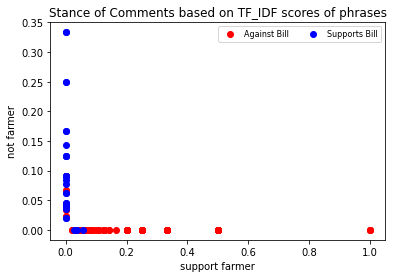

In [144]:
plot_1 = plt.scatter(X_f1[:, 0], X_f1[:, 1], color='red')
plot_2 = plt.scatter(X_f2[:, 0], X_f2[:, 1], color='blue')

plt.legend((plot_1,plot_2), ('Against Bill', 'Supports Bill'), numpoints=1, loc='upper right', ncol=3, fontsize=8)
plt.title("Stance of Comments based on TF_IDF scores of phrases")
plt.xlabel(n_gram_words[0])
plt.ylabel(n_gram_words[1])
plt.show()
